# Analyzing a spotify dataset

## Importing libs and reading CSV

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.colab import files
from IPython.display import display, HTML, clear_output
import asyncio
import aiohttp

In [31]:
uploaded = files.upload()

Saving spotify_data.csv to spotify_data (2).csv


In [32]:
df = pd.read_csv('spotify_data.csv')

In [33]:
df.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


## Data Cleaning

In [34]:
# Checking the number of NaN values in the whole dataset

df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,3361
album_id,0


**There are 3361 rows without artist genres**

🎯 **Goal: Read artist names via some Spotify API and get their genre(s)**

### Separating artists without genre

In [35]:
# Creating a separated df containing just the artists without genres and their number of followers
artists_without_genre = df[df['artist_genres'].isna()][['artist_name', 'artist_followers']]

# Selecting only artists with at least 10k followers
artists_without_genre = artists_without_genre[(artists_without_genre['artist_followers'] >= 10000)]

# Ordering by number of followers
artists_without_genre.sort_values(by='artist_followers', ascending=False, inplace=True)

display(artists_without_genre.tail())

,artist_name,artist_followers
355,Mandrazo,10272
1665,Prasewon,10229
5667,The Blue Notes,10148
620,Cloud,10130
3288,Olivia Herdt,10100


### Requesting Last.fm API

In [36]:
buffer = artists_without_genre['artist_name'].to_list()
artists_without_genre = []

In [37]:
# Removing duplicates
for artist in buffer:
  if artist not in artists_without_genre:
    artists_without_genre.append(artist)

buffer = []

# Setting URL and defining parameters
url = 'http://ws.audioscrobbler.com/2.0/'
params = {
    'method': 'artist.getinfo',
    'api_key': '548594b2115d6da3efd5d816a0916ef5',
    'format': 'json'
}


read_artist_genres = {}
genres_list = []
read = 0
size = len(artists_without_genre)

for artist in artists_without_genre:
  read += 1
  progress = (100 * read) / size
  display(f'{progress:.1f}% Done ({read} of {size})')
  clear_output(wait=True)
  # display(f"Reading the artist {artist}")
  params['artist'] = artist

  response = requests.get(url, params=params)

  if response.status_code != 200:
    display('Artist not found or error')
    display(response.status_code)
    continue

  data = response.json()

  if 'artist' in data:
    for tags in data['artist']['tags']['tag']:
      # display(f'Artist: {artist} | Tag: {tags['name']}')
      genres_list.append(tags['name'])

  genres_list = ", ".join(genres_list).lower()
  if genres_list:
    read_artist_genres[artist] = genres_list
  genres_list = []


'100.0% Done (991 of 991)'

### Merging with dataset

In [38]:
# Turning dict with artists and genres into a Series to merge with the original DF
read_artist_genres = pd.Series(read_artist_genres)

# Map artists with NaN genres to their corresponding genres
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(read_artist_genres)

### How many artists without genre are left?

In [39]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,571
album_id,0


### What can I do to fill the remaining artists with blank genre?

**Trying to find the remaining ones using another API (MusicBrainz):**

In [40]:
artists_without_genre = df[(df['artist_genres'].isna())]['artist_name'].drop_duplicates()

In [41]:
artists_without_genre = artists_without_genre.to_list()

In [42]:
len(artists_without_genre)

396

In [43]:
remaining_artists = {}

from time import sleep

url = 'https://musicbrainz.org/ws/2/artist'

headers = {
    "User-Agent": "MusicAnalytics/0.1 (paulorprocopio@gmail.com)"
}

params = {
    'fmt': 'json'
}


size = len(artists_without_genre)
read = 0

for artist in artists_without_genre:
  read += 1
  progress = (read * 100 / size)
  display(f'{progress:.1f}% Done ({read} of {size})')
  clear_output(wait=True)

  params['query'] = artist
  genres_list = []

  try:
    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
      print('Artist not found or error')
      continue

  except requests.exceptions.ConnectionError as e:
    display('Connection error')
    response = 0

    for retry in range(3):
      display(f'Trying again ({retry + 1})')

      try:
          sleep(0.25)
          response = requests.get(url, params=params, headers=headers)

          if response.status_code == 200:
            display('Successfully read after retry')
            break
      except:
          continue

  if response:
    data = response.json()

    if data['artists']:
      # print('Artist found')
      if 'tags' in data['artists'][0]:
        # print('Artist has at least a tag')
        genres = data['artists'][0]['tags']

        for genre in genres:
          genres_list.append(genre['name'])

        genres_list = ", ".join(genres_list).lower()
        remaining_artists[artist] = genres_list


'100.0% Done (396 of 396)'

In [44]:
remaining_artists = pd.Series(remaining_artists)
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(remaining_artists)

In [45]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,453
album_id,0


In [46]:
# Saving it into a new CSV
df.to_csv('spotify_data_treated.csv', index=False)
files.download('/content/spotify_data_treated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
uploaded = files.upload()

Saving spotify_data_treated (1).csv to spotify_data_treated (1) (2).csv


In [11]:

df = pd.read_csv('spotify_data_treated (1).csv')

## Understanding the dataset

### Does this dataset contains old songs, new songs or both?

In [49]:
# Transforming songs release date to datetime format

df['album_release_date'] = pd.to_datetime(df['album_release_date'])

In [50]:
# Visualizing the release year of the oldest and newest songs, and the  range between them

oldest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[0]
newest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[-1]
release_date_range = newest_song_year - oldest_song_year

display(HTML(f'The oldest song is from {oldest_song_year}.<br>The newest song is from {newest_song_year}.<br>The range is {release_date_range} years'))





**🎶 Therefore, the dataset contains both old and modern musics.**

### What's predominant, old or modern songs?

<Axes: xlabel='album_release_date', ylabel='Count'>

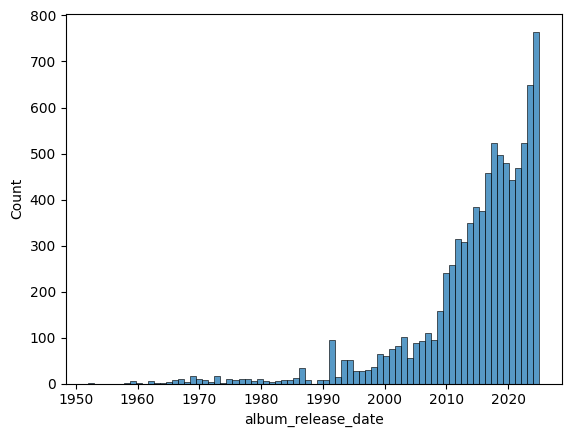

In [51]:
# Creating a histplot to visualize predominant release years

df['album_release_date'] = df['album_release_date'].dt.year
sns.histplot(df, x='album_release_date')

In [52]:
# Visualizing the number of songs per year
display(df['album_release_date'].value_counts().iloc[:10])

,count
album_release_date,
2025,765
2024,648
2023,523
2018,522
2019,496
2020,480
2022,468
2017,458
2021,443


In [ ]:
# Calculating the average year of song release

mean_release_date = df['album_release_date'].mean()

display(f"The average release date of songs in this dataset is {mean_release_date:.0f}")

'The average release date of songs in this dataset is 2015'

**Most of the songs are from 2010 - 2020, so modern songs are predominant.**

### How can we measure the success of a track?

In [ ]:
# We need to understand how to use the column 'track_popularity' to understand if a song is popular or not
# Maybe it could work as a rating or something? And what's the range of its values?

# Calculating the range
min_popularity = df['track_popularity'].min()
max_popularity = df['track_popularity'].max()
popularity_range = max_popularity - min_popularity

display(HTML(f'The max popularity is {max_popularity}.<br>The min popularity is {min_popularity}<br>The range of song popularity is {popularity_range}'))

So the popularity of tracks goes from 0 to 100.

With it, we can 'adapt' a rating from 0 to 10, just dividing the track's popularity by 10:

In [ ]:
df['track_popularity'] /= 10
display((df.sort_values(by='track_popularity', ascending=False).iloc[:10]))


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
457,1CPZ5BxNNd0n0nF4Orb9JS,Golden,4,9.9,False,HUNTR/X,87,3551538,k-pop,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.24
88,3yWuTOYDztXjZxdE2cIRUa,Opalite,3,9.7,False,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.92
101,1jgTiNob5cVyXeJ3WgX5bL,Elizabeth Taylor,2,9.5,False,Taylor Swift,100,145489371,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.47
337,1qbmS6ep2hbBRaEZFpn7BX,Man I Need,1,9.5,False,Olivia Dean,88,1499215,pop soul,0Bv6OJO0L5gcf20DMww54a,Man I Need,2025,3,single,3.06
103,03bTIHJElXZ0O0jqOQvAbY,Father Figure,4,9.4,True,Taylor Swift,100,145542136,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.54
1134,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,4,9.4,False,Billie Eilish,90,118692183,"alternative pop, electropop, dark pop",7aJuG4TFXa2hmE4z1yxc3n,HIT ME HARD AND SOFT,2024,10,album,3.50
450,02sy7FAs8dkDNYsHp4Ul3f,Soda Pop,3,9.4,False,Saja Boys,80,2234812,"k-pop, pop, korean, soundtrack, kpop",14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,2.51
460,1I37Zz2g3hk9eWxaNkj031,Your Idol,7,9.3,False,Saja Boys,80,2234812,"k-pop, pop, korean, soundtrack, kpop",14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.19
93,2x3mwb96B6TquRqMtbxUE1,Actually Romantic,7,9.3,True,Taylor Swift,100,145396321,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.72
97,5ylJtmaWPJ33cW3En7WOu0,Wood,9,9.3,True,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.50


## Exploratory Data Analysis (EDA)

### Who are the top artists, and what do they have in common?

In [12]:
# To filter the top artists, I can calculate the song popularity average of their songs, and select only those who have at least two songs on this dataset

# The artists also have a 'artist_popularity' measure which goes from 0 to 100

# Creating a series to get the number of songs by artists (times they appear on dataset)
num_songs_by_artist = df['artist_name'].value_counts()

# Filtering artist with more than one appearance
num_songs_by_artist = num_songs_by_artist[num_songs_by_artist > 1]

# Groupping artist by name and their songs avg. popularity
track_popularity_by_artist = df.groupby(["artist_name"])['track_popularity'].mean().sort_values(ascending=False)

# Groupping by artist name and their songs avg. duration
track_duration_by_artist = df.groupby(["artist_name"])["track_duration_min"].mean()

# Rounding the avg. track duration to 2 decimal places
track_duration_by_artist = round(track_duration_by_artist, 2)

# Getting the artists popularity index of the original DF
artists_popularity_index = df.drop_duplicates(subset='artist_name').set_index('artist_name')['artist_popularity']

# Calculating the number of explicit songs of each artist
number_of_explicit_songs = df[(df['explicit'] == True)]
number_of_explicit_songs = number_of_explicit_songs.groupby(['artist_name'])['explicit'].value_counts()
number_of_explicit_songs = number_of_explicit_songs.droplevel('explicit')

# Getting the artist genres/tags
artists_labels = df.drop_duplicates(subset=['artist_name']).set_index('artist_name')
artists_labels = artists_labels['artist_genres'].str.split(', ')


# Merging the series with number of songs and avg track popularity by artist names
artist_popularity_metrics = pd.DataFrame({
    'number_of_songs': num_songs_by_artist,
    'avg_track_popularity': track_popularity_by_artist,
    'avg_track_duration': track_duration_by_artist,
    'artist_popularity': artists_popularity_index,
    'explicit_songs': number_of_explicit_songs,
    'artist_labels': artists_labels
})

# Ordering by avg track popularity
artist_popularity_metrics = artist_popularity_metrics.dropna(subset=['number_of_songs']).sort_values(by='artist_popularity', ascending=False)

# Rounding the avg track popularity to 2 decimal places
artist_popularity_metrics['avg_track_popularity'] = round(artist_popularity_metrics['avg_track_popularity'], 2)

# Converting the Series number_of_songs and explicit_songs to int (removing decimal place)
artist_popularity_metrics['number_of_songs'] = artist_popularity_metrics['number_of_songs'].astype(int)
artist_popularity_metrics['explicit_songs'] = artist_popularity_metrics['explicit_songs'].fillna(0).astype(int)

# Creating a explicit dependency metric
artist_popularity_metrics['explicit_dependency'] = round((100 * artist_popularity_metrics['explicit_songs']) / artist_popularity_metrics['number_of_songs'], 2)

artist_popularity_metrics.head(15)

,number_of_songs,avg_track_popularity,avg_track_duration,artist_popularity,explicit_songs,artist_labels,explicit_dependency
artist_name,,,,,,,
Taylor Swift,324,60.05,3.90,100,46,"[country, pop, indie, folk]",14.20
Bad Bunny,56,73.34,3.65,95,45,"[reggaeton, trap latino, urbano latino, latin]",80.36
Drake,84,65.89,3.88,95,73,[rap],86.90
The Weeknd,141,60.79,4.38,93,70,"[r&b pop, alternative r&b, hip hop, synthpop]",49.65
Justin Bieber,55,66.27,3.00,91,10,"[pop, contemporary r&b]",18.18
Sabrina Carpenter,34,79.50,3.05,91,23,[pop],67.65
Ariana Grande,94,63.91,3.32,90,39,[pop],41.49
Rihanna,52,65.58,3.88,90,17,"[pop, r&b]",32.69
Billie Eilish,61,73.89,3.50,90,6,"[alternative pop, electropop, dark pop]",9.84


### What are the parameters that make a song popular?

#### How track duration impacts in artists success

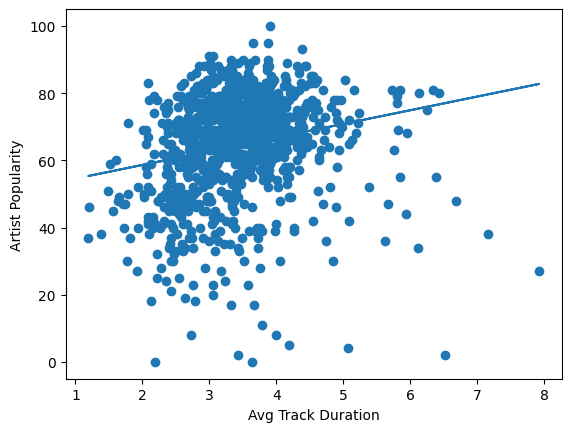

In [13]:
x = artist_popularity_metrics['avg_track_duration']
y = artist_popularity_metrics['artist_popularity']

fig, ax = plt.subplots()

plt.scatter(x, y)


m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.xlabel('Avg Track Duration')
plt.ylabel('Artist Popularity')

plt.show()

Artists with songs averaging between 3 and 4 minutes appear to be more popular, but the relationship is weak.

#### What are the top genres?

**Creating a chart that shows the top genres between the top 100 artists (by artist popularity):**

In [14]:
# Exploded version (with separated labels to plot)
artist_popularity_metrics_exploded = artist_popularity_metrics.explode('artist_labels')
top_100_artists = artist_popularity_metrics_exploded.iloc[:100]

top_100_artists

,number_of_songs,avg_track_popularity,avg_track_duration,artist_popularity,explicit_songs,artist_labels,explicit_dependency
artist_name,,,,,,,
Taylor Swift,324,60.05,3.90,100,46,country,14.20
Taylor Swift,324,60.05,3.90,100,46,pop,14.20
Taylor Swift,324,60.05,3.90,100,46,indie,14.20
Taylor Swift,324,60.05,3.90,100,46,folk,14.20
Bad Bunny,56,73.34,3.65,95,45,reggaeton,80.36
...,...,...,...,...,...,...,...
Olivia Rodrigo,68,60.57,3.05,85,25,alternative pop,36.76
Olivia Rodrigo,68,60.57,3.05,85,25,pop punk,36.76
Daddy Yankee,2,37.50,3.28,85,0,reggaeton,0.00


In [15]:
top_100_artists.loc[(top_100_artists['artist_labels'].str.contains('hip hop')) | (top_100_artists['artist_labels'].str.contains('hip-hop'))] = 'hip hop'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('pop')] = 'pop'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('rap')] = 'rap'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('r&b')] = 'r&b'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('metal')] = 'metal'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('rock')] = 'rock'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('latin')] = 'latin'

top_100_artists_labels = top_100_artists['artist_labels'].value_counts()
other_labels_amount = top_100_artists_labels.iloc[7:]
other_labels_amount = other_labels_amount[(other_labels_amount > 1)].sum()
top_100_artists_labels = top_100_artists_labels.iloc[:7]
top_100_artists_labels = pd.concat([top_100_artists_labels, pd.Series([other_labels_amount], index=['other'])])

top_100_artists_labels

# top_100_artists_labels = top_100_artists_labels[(top_100_artists_labels > 1)]
# top_100_artists_labels['other'] = other_labels_amount

# top_100_artists_labels = top_100_artists_labels.sort_values(ascending=False)
# top_100_artists_labels = top_100_artists_labels.iloc[:8]

# top_100_artists_labels


/tmp/ipython-input-3260492646.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hip hop' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  top_100_artists.loc[(top_100_artists['artist_labels'].str.contains('hip hop')) | (top_100_artists['artist_labels'].str.contains('hip-hop'))] = 'hip hop'
/tmp/ipython-input-3260492646.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hip hop' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  top_100_artists.loc[(top_100_artists['artist_labels'].str.contains('hip hop')) | (top_100_artists['artist_labels'].str.contains('hip-hop'))] = 'hip hop'
/tmp/ipython-input-3260492646.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'h

,0
pop,27
rap,15
hip hop,11
r&b,6
latin,6
rock,5
reggaeton,4
other,10


Text(0.5, 1.0, 'Top genres on top 100 artists')

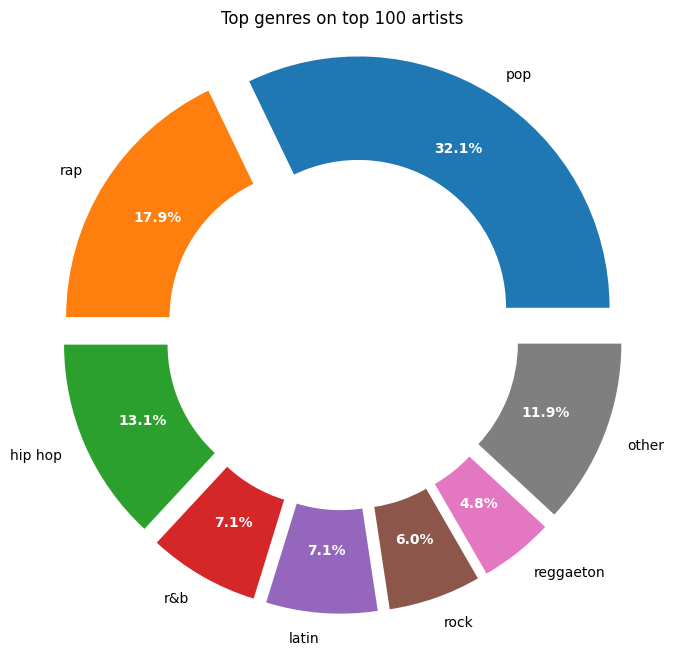

In [16]:
fig, ax = plt.subplots()

labels = top_100_artists_labels.index
percent = top_100_artists_labels

explode = [0.2 for label in top_100_artists_labels.index]

wedges, texts, autotexts = ax.pie(
    percent, # -> Values
    labels=labels, # -> Labels (Series index)
    labeldistance=1.1, # -> Label distance from chart
    explode=explode, # -> Distance between chart pieces
    autopct='%1.1f%%', # -> Auto-calculating the percentage
    radius=1.7, # -> Increasing circle radius
    wedgeprops=dict(width=0.7), # -> Turning pie into a donut (adding a circle inside it)
    pctdistance=0.75 # -> Adjusting the percentage distance from chart
)

# Just percentages
for t in autotexts:
    t.set_color('white')
    t.set_fontsize(10)
    t.set_fontweight('bold')

plt.title('Top genres on top 100 artists', pad=90)

#### What are the predominant countries among the top 100 artists?

In [19]:


url = 'https://musicbrainz.org/ws/2/artist'

headers = {
    "User-Agent": "MusicAnalytics/0.1 (paulorprocopio@gmail.com)"
}

params = {
    'fmt': 'json'
}

size = len(top_100_artists_list)
read = 0

for artist in top_100_artists_list:
  read += 1
  progress = (read * 100) / size
  display(f'{progress:.1f}% Done ({read} of {size})')
  clear_output(wait=True)
  params['query'] = artist

  try:
    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
      print('Artist not found or error')
      retry(params, headers, attempts=5)
      continue

  except requests.exceptions.ConnectionError as e:
    display('Connection error')
    retry(params, headers, attempts=5)

  if response:
    data = response.json()

    if data['artists']:
      print('Artist found')
      if 'country' in data['artists'][0]:
        # display(f'The artist {artist} is from {data['artists'][0]['country']}')
        artists_nationalities[artist] = data['artists'][0]['country']




KeyboardInterrupt: 

In [18]:
top_100_artists_list = artist_popularity_metrics.iloc[:100].index.to_list()
artists_nationalities = {}

In [27]:
async def fetch(session, url, params, headers, retries, lote):
  for attempt in range(retries):
    async with session.get(url, params=params, headers=headers) as response:

      if response.status != 200:
        print(f'Error {response.status}. Trying again {(attempt)} - Lote {lote}')
        await asyncio.sleep(1)
        continue

      print(f'Success! Status code: {response.status} - Lote {lote}')
      return await response.json()

  return []

async def main(url, params, artists_list, headers, retries):
  RATE = 3
  size = len(artists_list)

  mod = size % RATE
  lote = 0

  async with aiohttp.ClientSession() as session:
    tasks = []

    for i in range(0, len(artists_list), RATE):

      if mod != 0 and i == (size - mod):
        display(f'Restam {size - (size - mod)} requests')
        batch = artists_list[-mod:]

      else:
        batch = artists_list[i:i+RATE]

      lote += 1
      display(f'Processando o {lote} lote: ')
      for artist in batch:
        artist_params = params.copy()
        artist_params['query'] = artist
        tasks.append(fetch(session, url, artist_params, headers, retries, lote))

      await asyncio.sleep(1)

    results = await asyncio.gather(*tasks)

    for result in results:
      if result:
        if 'artists' in result:
          if 'country' in result['artists'][0]:
            display(f'The artist {result['artists'][0]['name']} is from {result['artists'][0]['country']}')

In [28]:
headers = {
    "User-Agent": "ProjectAnalysis/0.3 (johanauf@gmail.com)"
}

params = {
    'fmt': 'json'
}

await main(
    url='https://musicbrainz.org/ws/2/artist',
    params=params,
    headers=headers,
    artists_list=top_100_artists_list,
    retries=3
    )

'Processando o 1 lote: '

'Processando o 2 lote: '

'Processando o 3 lote: '

'Processando o 4 lote: '

'Processando o 5 lote: '

'Processando o 6 lote: '

'Processando o 7 lote: '

'Processando o 8 lote: '

'Processando o 9 lote: '

'Processando o 10 lote: '

'Processando o 11 lote: '

'Processando o 12 lote: '

'Processando o 13 lote: '

'Processando o 14 lote: '

'Processando o 15 lote: '

'Processando o 16 lote: '

'Processando o 17 lote: '

'Processando o 18 lote: '

'Processando o 19 lote: '

'Processando o 20 lote: '

'Processando o 21 lote: '

'Processando o 22 lote: '

'Processando o 23 lote: '

'Processando o 24 lote: '

'Processando o 25 lote: '

'Processando o 26 lote: '

'Processando o 27 lote: '

'Processando o 28 lote: '

'Processando o 29 lote: '

'Processando o 30 lote: '

'Processando o 31 lote: '

'Processando o 32 lote: '

'Processando o 33 lote: '

'Restam 1 requests'

'Processando o 34 lote: '

Success! Status code: 200 - Lote 22
Success! Status code: 200 - Lote 21
Success! Status code: 200 - Lote 10
Success! Status code: 200 - Lote 20
Success! Status code: 200 - Lote 10
Error 503. Trying again 0 - Lote 23
Error 503. Trying again 0 - Lote 8
Error 503. Trying again 0 - Lote 7
Error 503. Trying again 0 - Lote 21
Error 503. Trying again 0 - Lote 24
Error 503. Trying again 0 - Lote 33
Error 503. Trying again 0 - Lote 17
Success! Status code: 200 - Lote 34
Success! Status code: 200 - Lote 33
Error 503. Trying again 0 - Lote 20
Error 503. Trying again 0 - Lote 17
Error 503. Trying again 0 - Lote 32
Error 503. Trying again 0 - Lote 22
Error 503. Trying again 0 - Lote 17
Error 503. Trying again 0 - Lote 10
Error 503. Trying again 0 - Lote 8
Error 503. Trying again 0 - Lote 18
Error 503. Trying again 0 - Lote 16
Error 503. Trying again 0 - Lote 9
Error 503. Trying again 0 - Lote 25
Error 503. Trying again 0 - Lote 6
Error 503. Trying again 0 - Lote 29
Error 503. Trying again 0 - Lote 

'The artist Travis Scott is from US'

'The artist Olivia Dean is from GB'

'The artist SZA is from US'

'The artist Chris Brown is from US'

'The artist Tyler, The Creator is from US'

'The artist Alex Warren is from US'

'The artist Pitbull is from US'

'The artist Young Thug is from US'

'The artist TWICE is from KR'

'The artist Katy Perry is from US'

'The artist Teddy Swims is from US'

'The artist A$AP Rocky is from US'

'The artist Queen is from GB'

'The artist Akon is from SN'

In [64]:
artists_nationalities = pd.Series(artists_nationalities)

In [65]:
artists_nationalities

,0


In [22]:
async def fetch(session, url, params, retries, lote):
  for attempt in range(retries):
    async with session.get(url, params=params) as response:

      if response.status != 200:
        print(f'Error {response.status}. Trying again {(attempt)} - Lote {lote}')
        await asyncio.sleep(1)
        continue

      print(f'Success! Status code: {response.status} - Lote {lote}')
      return await response.json()

  return []

async def main(url, params, artists_list, retries):
  RATE = 20
  size = len(artists_list)

  mod = size % RATE
  lote = 0

  async with aiohttp.ClientSession() as session:
    tasks = []

    for i in range(0, len(artists_list), RATE):

      if mod != 0 and i == (size - mod):
        display(f'Restam {size - (size - mod)} requests')
        batch = artists_list[-mod:]

      else:
        batch = artists_list[i:i+RATE]

      lote += 1
      display(f'Processando o {lote} lote: ')
      for artist in batch:
        artist_params = params.copy()
        artist_params['query'] = artist
        tasks.append(fetch(session, url, artist_params, retries, lote))

      await asyncio.sleep(10)

    results = await asyncio.gather(*tasks)


In [24]:


url = 'http://ws.audioscrobbler.com/2.0/'
params = {
    'method': 'artist.getinfo',
    'api_key': '548594b2115d6da3efd5d816a0916ef5',
    'format': 'json'
}

await main(
    url=url,
    params=params,
    artists_list=top_100_artists_list,
    retries=3
    )

'Processando o 1 lote: '

'Processando o 2 lote: '

'Processando o 3 lote: '

'Processando o 4 lote: '

'Processando o 5 lote: '

Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 4
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 2
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 2
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 2
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 2
Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 1
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 5
Success! Status code: 200 - Lote 3
Success! Status code: 200 - Lote 2
Success! Status code: 200 - Lote 3
Success! Status code